<a href="https://colab.research.google.com/github/diegomrodrigues/generative_models_experiments/blob/main/VAE%20on%20Moon%20Data%20did%20not%20converged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

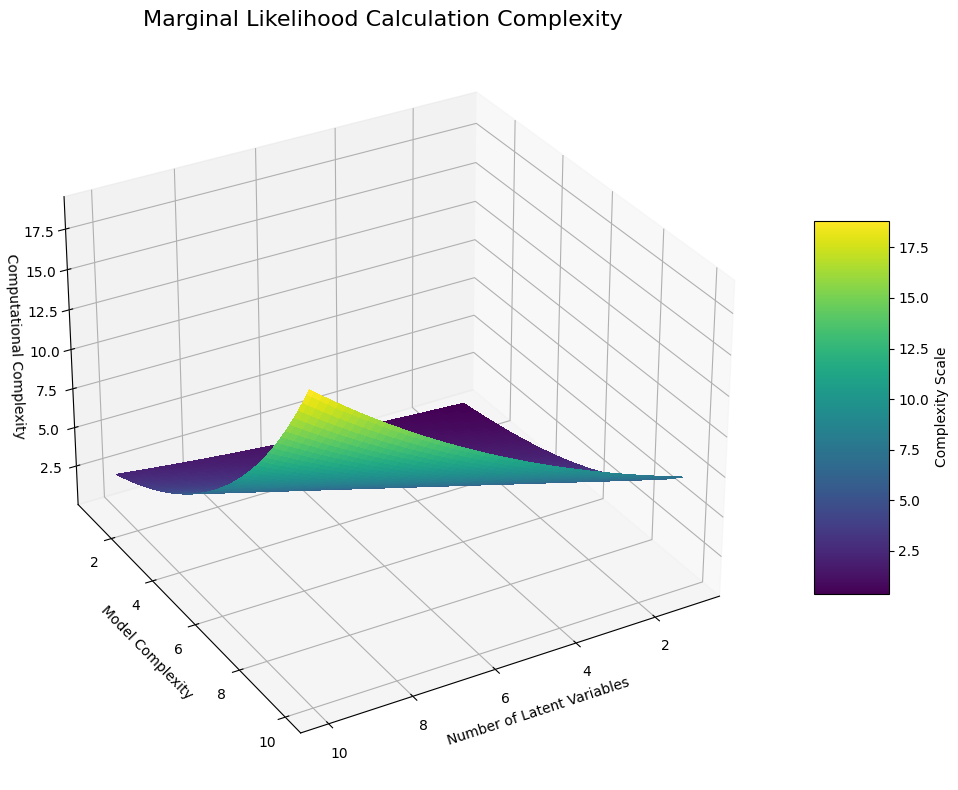

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def complexity_function(x, y):
    return np.exp(0.1 * x + 0.2 * y) - 1

# Create data points
num_latent_vars = np.linspace(1, 10, 100)
model_complexity = np.linspace(1, 10, 100)
X, Y = np.meshgrid(num_latent_vars, model_complexity)
Z = complexity_function(X, Y)

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

# Customize the plot
ax.set_xlabel('Number of Latent Variables')
ax.set_ylabel('Model Complexity')
ax.set_zlabel('Computational Complexity')
ax.set_title('Marginal Likelihood Calculation Complexity', fontsize=16)

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Complexity Scale')

# Rotate the plot for better visibility
ax.view_init(elev=30, azim=60)

# Show the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0, Average Loss: 2.7339
Epoch 50, Average Loss: 1.5449
Epoch 100, Average Loss: 1.5315
Epoch 150, Average Loss: 1.5174
Epoch 200, Average Loss: 1.5314
Epoch 250, Average Loss: 1.5282
Epoch 300, Average Loss: 1.5354
Epoch 350, Average Loss: 1.5382
Epoch 400, Average Loss: 1.5286
Epoch 450, Average Loss: 1.5267


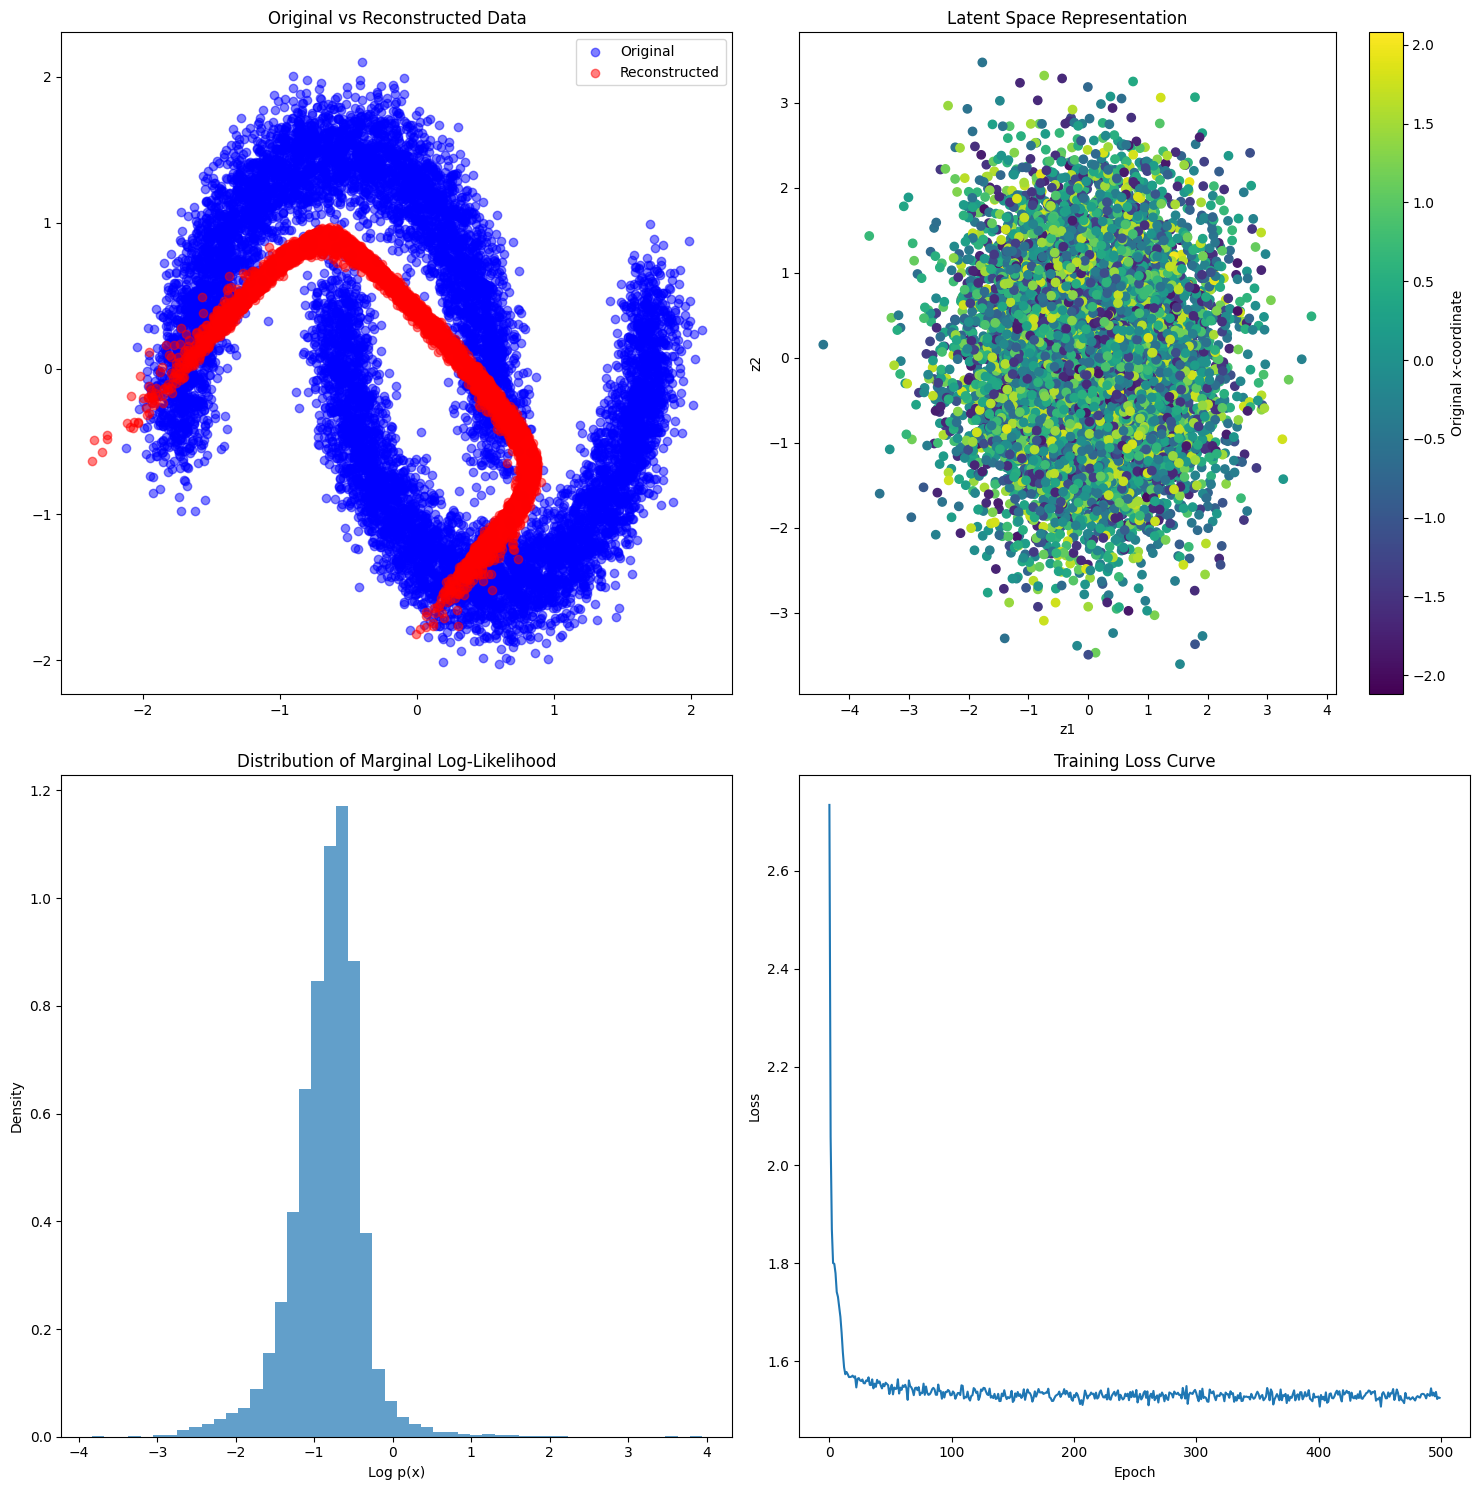

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate moons dataset
X, _ = make_moons(n_samples=10000, noise=0.1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Improved VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[128, 64, 16], latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(input_dim, h_dim),
                    nn.BatchNorm1d(h_dim),
                    nn.ReLU())
            )
            input_dim = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.ReLU())
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Linear(hidden_dims[-1], 2)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = self.decoder(h)
        return self.final_layer(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_vae(model, dataloader, optimizer, scheduler, device, epochs=500):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')
    return losses

# Create and train VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=16).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20, verbose=True)
losses = train_vae(vae, dataloader, optimizer, scheduler, device)

# Visualization functions
def plot_original_vs_reconstructed(ax, model, data):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data.to(device))
    recon = recon.cpu()

    ax.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, label='Original')
    ax.scatter(recon[:, 0], recon[:, 1], c='red', alpha=0.5, label='Reconstructed')
    ax.legend()
    ax.set_title('Original vs Reconstructed Data')

def plot_latent_space(ax, model, data):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(data.to(device))
        z = model.reparameterize(mu, logvar)
    z = z.cpu()

    scatter = ax.scatter(z[:, 0], z[:, 1], c=data[:, 0], cmap='viridis')
    ax.set_title('Latent Space Representation')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    return scatter

def plot_marginal_likelihood(ax, model, data, num_samples=1000):
    model.eval()
    log_likelihoods = []

    for _ in range(num_samples):
        with torch.no_grad():
            recon, mu, logvar = model(data.to(device))
            z = model.reparameterize(mu, logvar)

            log_p_x_given_z = -F.mse_loss(recon, data.to(device), reduction='none').sum(dim=1)
            log_p_z = torch.distributions.Normal(0, 1).log_prob(z).sum(dim=1)
            log_q_z_given_x = torch.distributions.Normal(mu, torch.exp(0.5 * logvar)).log_prob(z).sum(dim=1)

            log_likelihood = log_p_x_given_z + log_p_z - log_q_z_given_x
            log_likelihoods.append(log_likelihood)

    log_likelihoods = torch.stack(log_likelihoods, dim=0)
    marginal_log_likelihood = torch.logsumexp(log_likelihoods, dim=0) - np.log(num_samples)

    ax.hist(marginal_log_likelihood.cpu().numpy(), bins=50, density=True, alpha=0.7)
    ax.set_title('Distribution of Marginal Log-Likelihood')
    ax.set_xlabel('Log p(x)')
    ax.set_ylabel('Density')

def plot_loss_curve(ax, losses):
    ax.plot(losses)
    ax.set_title('Training Loss Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

# Generate visualizations in a matrix
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plot_original_vs_reconstructed(axs[0, 0], vae, X_tensor)
scatter = plot_latent_space(axs[0, 1], vae, X_tensor)
plot_marginal_likelihood(axs[1, 0], vae, X_tensor)
plot_loss_curve(axs[1, 1], losses)

plt.colorbar(scatter, ax=axs[0, 1], label='Original x-coordinate')
plt.tight_layout()
plt.show()

Epoch 0, Average Loss: 1.9943
Epoch 9, Average Loss: 1.5834


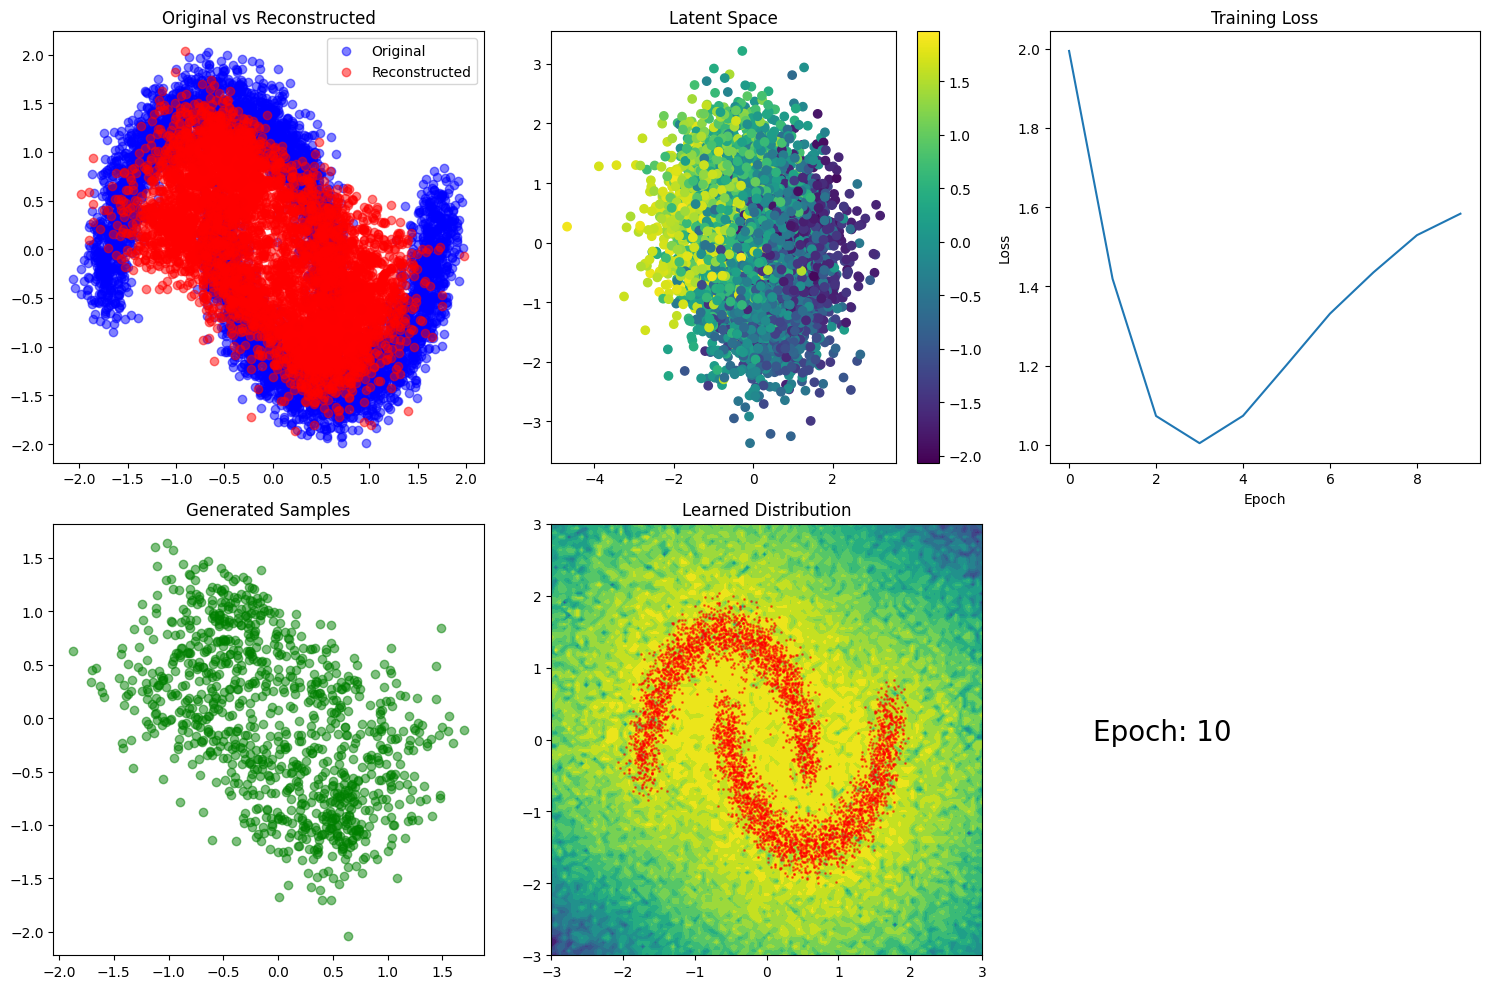

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate moons dataset
X, _ = make_moons(n_samples=5000, noise=0.1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Simplified VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Modified loss function with annealing
def loss_function(recon_x, x, mu, logvar, beta):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

def visualize_progress(model, data, losses, axs, epoch):
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(data.to(device))
        z = model.reparameterize(mu, logvar)

    recon = recon.cpu().detach().numpy()
    z = z.cpu().detach().numpy()
    data = data.cpu().numpy()

    axs[0, 0].clear()
    axs[0, 0].scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, label='Original')
    axs[0, 0].scatter(recon[:, 0], recon[:, 1], c='red', alpha=0.5, label='Reconstructed')
    axs[0, 0].legend()
    axs[0, 0].set_title('Original vs Reconstructed')

    axs[0, 1].clear()
    scatter = axs[0, 1].scatter(z[:, 0], z[:, 1], c=data[:, 0], cmap='viridis')
    axs[0, 1].set_title('Latent Space')
    plt.colorbar(scatter, ax=axs[0, 1])

    axs[0, 2].clear()
    axs[0, 2].plot(losses)
    axs[0, 2].set_title('Training Loss')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Loss')

    # Generate samples from the latent space
    with torch.no_grad():
        sample_z = torch.randn(1000, 2).to(device)
        samples = model.decode(sample_z).cpu().detach().numpy()
    axs[1, 0].clear()
    axs[1, 0].scatter(samples[:, 0], samples[:, 1], c='green', alpha=0.5)
    axs[1, 0].set_title('Generated Samples')

    # Plot the learned distribution in the original space
    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    grid_samples = np.column_stack([xx.ravel(), yy.ravel()])
    grid_tensor = torch.FloatTensor(grid_samples).to(device)
    with torch.no_grad():
        _, mu, logvar = model(grid_tensor)
        z = model.reparameterize(mu, logvar)
        recon = model.decode(z)
        log_probs = -F.mse_loss(recon, grid_tensor, reduction='none').sum(1).cpu().detach().numpy()
    log_probs = log_probs.reshape(xx.shape)

    axs[1, 1].clear()
    axs[1, 1].contourf(xx, yy, log_probs, levels=20, cmap='viridis')
    axs[1, 1].scatter(data[:, 0], data[:, 1], c='red', alpha=0.5, s=1)
    axs[1, 1].set_title('Learned Distribution')

    axs[1, 2].clear()
    axs[1, 2].text(0.1, 0.5, f'Epoch: {epoch}', fontsize=20)
    axs[1, 2].axis('off')

    plt.tight_layout()

# Training function with visualization
def train_vae(model, dataloader, optimizer, device, epochs=500):
    model.train()
    losses = []
    betas = np.linspace(0, 1, epochs)  # KL annealing

    #fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    #plt.ion()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, betas[epoch])
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)

        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')
        #    visualize_progress(model, X_tensor, losses, axs, epoch)
        #    plt.pause(0.1)

    #plt.ioff()
    #plt.show()
    return losses

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE().to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    losses = train_vae(vae, dataloader, optimizer, device, epochs=10)

    # Final visualization
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    visualize_progress(vae, X_tensor, losses, axs, 10)  # 499 is the last epoch if epochs=500
    plt.tight_layout()
    plt.show()

Epoch 0, Average Loss: 0.4955
Epoch 10, Average Loss: 0.4935
Epoch 20, Average Loss: 0.4931
Epoch 30, Average Loss: 0.4933
Epoch 40, Average Loss: 0.4929
Epoch 50, Average Loss: 0.4932
Epoch 60, Average Loss: 0.4930
Epoch 70, Average Loss: 0.4931
Epoch 80, Average Loss: 0.4934
Epoch 90, Average Loss: 0.4930
Epoch 99, Average Loss: 0.4930


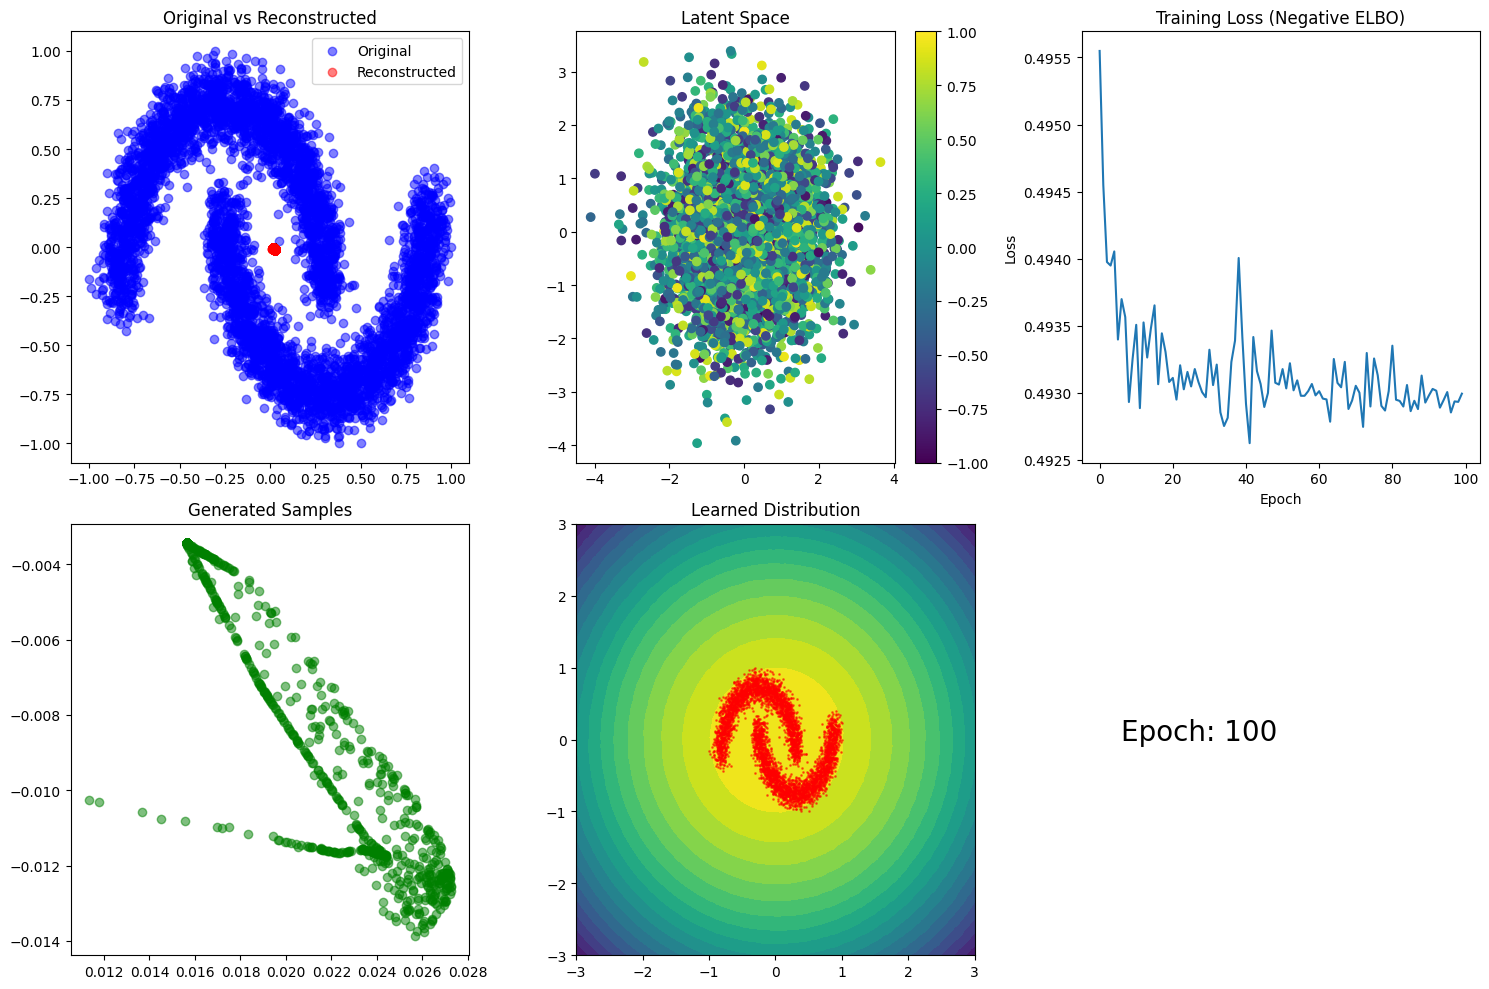

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate moons dataset
X, _ = make_moons(n_samples=5000, noise=0.1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Improved VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def elbo(self, x, x_recon, mu, logvar, beta=1.0):
        MSE = F.mse_loss(x_recon, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + beta * KLD

# Training function
def train_vae(model, dataloader, optimizer, device, epochs=100, beta=1.0):
    model.train()
    losses = []

    #fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    #plt.ion()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = model.elbo(data, recon_batch, mu, logvar, beta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')
            #visualize_progress(model, X_tensor, losses, axs, epoch)
            #plt.pause(0.1)

    #plt.ioff()
    #plt.show()
    return losses


# Visualization function (unchanged)
def visualize_progress(model, data, losses, axs, epoch):
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(data.to(device))
        z = model.reparameterize(mu, logvar)

    recon = recon.cpu().detach().numpy()
    z = z.cpu().detach().numpy()
    data = data.cpu().numpy()

    axs[0, 0].clear()
    axs[0, 0].scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, label='Original')
    axs[0, 0].scatter(recon[:, 0], recon[:, 1], c='red', alpha=0.5, label='Reconstructed')
    axs[0, 0].legend()
    axs[0, 0].set_title('Original vs Reconstructed')

    axs[0, 1].clear()
    scatter = axs[0, 1].scatter(z[:, 0], z[:, 1], c=data[:, 0], cmap='viridis')
    axs[0, 1].set_title('Latent Space')
    plt.colorbar(scatter, ax=axs[0, 1])

    axs[0, 2].clear()
    axs[0, 2].plot(losses)
    axs[0, 2].set_title('Training Loss (Negative ELBO)')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Loss')

    with torch.no_grad():
        sample_z = torch.randn(1000, 2).to(device)
        samples = model.decode(sample_z).cpu().detach().numpy()
    axs[1, 0].clear()
    axs[1, 0].scatter(samples[:, 0], samples[:, 1], c='green', alpha=0.5)
    axs[1, 0].set_title('Generated Samples')

    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    grid_samples = np.column_stack([xx.ravel(), yy.ravel()])
    grid_tensor = torch.FloatTensor(grid_samples).to(device)
    with torch.no_grad():
        _, mu, logvar = model(grid_tensor)
        z = model.reparameterize(mu, logvar)
        recon = model.decode(z)
        log_probs = -F.mse_loss(recon, grid_tensor, reduction='none').sum(1).cpu().detach().numpy()
    log_probs = log_probs.reshape(xx.shape)

    axs[1, 1].clear()
    axs[1, 1].contourf(xx, yy, log_probs, levels=20, cmap='viridis')
    axs[1, 1].scatter(data[:, 0], data[:, 1], c='red', alpha=0.5, s=1)
    axs[1, 1].set_title('Learned Distribution')

    axs[1, 2].clear()
    axs[1, 2].text(0.1, 0.5, f'Epoch: {epoch}', fontsize=20)
    axs[1, 2].axis('off')

    plt.tight_layout()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE().to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    losses = train_vae(vae, dataloader, optimizer, device)

    # Final visualization
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    visualize_progress(vae, X_tensor, losses, axs, 100)  # 499 is the last epoch if epochs=500
    plt.tight_layout()
    plt.show()